# Regresión II: No entiendo lo que dicen

Debido a la contingencia ocasionada por el COVID, las teleconferencias son ahora mucho más comunes. Sin embargo, muchas veces el ruido de fondo no permite enender que es lo que una persona ha dicho, lo que ocasiona demoras en las reuniones. Además, el ruido de fondo (tráfico, perros, otras personas hablando, lluvia, etc..) puede ser un distractor importante en las reuniones. El profesor Alexander esta un poco cansado con esta situación, ya qu elas reuniones se alargan más de lo debido, y esto le quita tiempo para realizar otras actividades. Como los estudiantes de Machine LEarning ya saben utilizar redes neuronales, el profesor Alexander quiere que sus estudiantes desarrollen un sistema de mejora del audio, la idea es que los estudiantes desarrollen un modelo utilizando redes neuronales, que sea capaz de reducir el ruido de fondo de las señales de audio que se procesan. 

Para la realización de este proyecto el estudiante debera:

1. Crear una base de datos con señales de personas hablando, y de diferentes ruidos de fondo, los cuales deben ser mezclados para generar las señales de entrada en el modelo de regresión. Tenga en cuenta las sigueintes consideraciones:
    * Una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades que se les ocurra de ruido de fondo y de señales de habla. Además la base de datos debe contener diferentes muestras de diferentes personas, invluyendo niños, niñas, mujeres y hombres. El objetivo es generalizar, no memorizar patrones, para esto debemos darle suficiente información a la red.
    * Una señal de voz puede tener entre 8000 y 40000 mmuestras por segundo de grabación. Esto es bastante para ser utilizado como entrada en la red. recuerde que entre mayor dimensionalidad en los datos de entrada, mayor será la complejidad de la red necesaria. Para disminuir la complejidad el profesor Alexander recomienda el uso de la densidad espectral de potencia (PSD) utilizando un número fijo de bins frecuenciales. La PSD representa la distribucion en frecuencia de la potencia de la señal.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.

Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir si el profesor Alexander quiere probar con una señal de voz que él produzca, entonces él solo deberia ingresar la señal de voz y el programa debería proporcionar a la salida una estimación de la señal de voz mejorada, con el ruido de fondo reducido.

Además el profesor quiere que contesten las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

Par ala entrega del proyecto deben porporcionar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Set 0 for GPU usage (if you have CUDA and everything setup), leave -1 for CPU

from scipy.io import wavfile
#from scipy.signal import welch as PSD
from scipy.signal import resample
import matplotlib.pyplot as plt
import numpy as np

#Constantes de Los Datos
SECOND_LENGTHS = 2
EXPECTED_HZ = 8000
CHUNK_WINDOW = 0.2

# Manejo de Datos
## Verificación de Datos

In [2]:
PALABRAS = ['grabar','campo','amanecer','ruido','universidad','habito','rector','vocabulario','dificil','verde']
WORDSAMPLES = 10 # Total de variaciones de cada palabra
NOISES = ['cars1','fan1','fan2','water1']
NOISE_AMPLITUDE = 0.5 # a factor to scale down the noise, so it is louder or quieter


def isValidFile(filename):
    '''Verifies that a file is a valid wav file.
    Verifies that it has EXPECTED_HZ frequency, and length of SECOND_LENGTHS'''
    SAMPLE_HZ, palabra = wavfile.read(filename)
    if not (EXPECTED_HZ == SAMPLE_HZ and EXPECTED_HZ*SECOND_LENGTHS == len(palabra)):
        return False
    if palabra.dtype != 'int16':
        return False
    
    return True

#Verificamos que los datos esten correctos 
for palabra in PALABRAS:
    for i in range(1,WORDSAMPLES+1): #[1,2,...,10]
        assert isValidFile('database/' + palabra + str(i) + '.wav'), 'Invalid File: {0}'.format(palabra + i)
        
for noise in NOISES:
    assert isValidFile('database/' + palabra + str(i) + '.wav'), 'Invalid File: {0}'.format(noise)

## Generación de Datos, Mezcla de Ruidos

In [3]:
mixednoise = [] #Array that contains words with mixed noise in it
mixednoise_target = [] #Array that contains the word, without any noise in it


CROP_TO = 10000 # Set to None to not crop input
#CROP_TO = None # Don't crop

#Mix every signal
for palabra in PALABRAS:
    for i in range(1,WORDSAMPLES+1): #[1,2,...,10]    
        for noise in NOISES:
            palabra_filename = 'database/' + palabra + str(i) + '.wav'
            noise_filename = 'noises/' + noise + '.wav'
            SAMPLE_HZ, palabra_array = wavfile.read(palabra_filename)
            SAMPLE_HZ, noise_array = wavfile.read(noise_filename)
            
            noise_array = np.around(noise_array * NOISE_AMPLITUDE).astype('int16') # Scale amplitude
            if np.shape(palabra_array) == (16000,2):
                palabra_array = palabra_array[:,0] # Take first audio track if mono
            
            noise_mixed = noise_array + palabra_array
            
            mixednoise.append(noise_mixed)
            mixednoise_target.append(palabra_array)
            # Uncomment to display all combinations graph (10*10*4 = 400)
            #plt.plot(noise_array + palabra_array)
            #plt.show()

if CROP_TO is not None:
    mixednoise = [array[:CROP_TO] for array in mixednoise]
    mixednoise_target = [array[:CROP_TO] for array in mixednoise_target]

X = np.row_stack(mixednoise)
X_target = np.row_stack(mixednoise_target)

#Normalizamos cada fila
X_norm = X / X.std(axis=1,ddof=1, keepdims=True)
X_target_norm = X_target / X_target.std(axis=1,ddof=1,keepdims=True)

## Separación de Datos Entrenamiento, Validación y Prueba

In [18]:
from random import sample as RandomSubSample
#Separamos los datos, tenemos 40 variaciones de cada palabra, tomamos 4 para validación y 8 de prueba (por cada palabra)
noise_wordvariations = WORDSAMPLES * len(NOISES) # 40

validation_picks = 4
test_picks = 8

# Generamos indexes, en el rango de cada palabra (van en saltos de 40 en 40 cada variación de palabra)
validation_indexes = []
test_indexes = []
for i in range(WORDSAMPLES):
    indexes = RandomSubSample(range(noise_wordvariations*i, noise_wordvariations*(i+1)), validation_picks +  test_picks)
    #print(indexes)
    validation_indexes.extend(indexes[:validation_picks])
    test_indexes.extend(indexes[validation_picks:])
    
# Tomamos los indices aleatorios
X_test = X_norm[test_indexes,:]
X_validation = X_norm[validation_indexes,:]

X_test_target = X_target_norm[test_indexes,:]
X_validation_target = X_target_norm[validation_indexes,:]

# Tomamos los datos de entrenamiento, quitando las filas tomadas anteriormente
X_train = np.delete(X_norm, validation_indexes + test_indexes, axis=0)
X_train_target = np.delete(X_target_norm, validation_indexes + test_indexes, axis=0)

## Reducción de Datos

In [5]:
# Resampleamos Cada Fila
resample_to = 1600
def ResampleDataset(matrix, resample_to):
    '''Receives a dataset matrix, and resamples each matrix row, to contain resample_to columns'''
    reduced = [resample(row, resample_to) for row in matrix]
    return np.row_stack(reduced)

X_test_target_reduced = ResampleDataset(X_test_target,resample_to)

#plt.plot(X_test_target[20])
#plt.show()
#plt.plot(X_test_target_reduced[20])


# Entrenamiento
## Creación del modelo

In [19]:
from keras import models,layers

model = models.Sequential()
model.add(layers.Dense(4000,activation = 'relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dense(X_train_target.shape[1])) # Multiple output
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [20]:
history = model.fit(X_train, X_train_target, validation_data=(X_validation,X_validation_target) ,epochs=2000, batch_size = 8000, verbose=1)

Epoch 1/2000
1/1 [==============================] - 1s 767ms/step - loss: 1.4027 - mae: 0.8108 - val_loss: 9.0052 - val_mae: 2.4657
Epoch 2/2000
1/1 [==============================] - 0s 155ms/step - loss: 8.2017 - mae: 2.3493 - val_loss: 1.0664 - val_mae: 0.5509
Epoch 3/2000
1/1 [==============================] - 0s 159ms/step - loss: 1.0098 - mae: 0.5187 - val_loss: 1.0554 - val_mae: 0.5359
Epoch 4/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.9974 - mae: 0.5027 - val_loss: 1.0522 - val_mae: 0.5312
Epoch 5/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.9921 - mae: 0.4976 - val_loss: 1.0495 - val_mae: 0.5315
Epoch 6/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.9856 - mae: 0.4979 - val_loss: 1.0427 - val_mae: 0.5294
Epoch 7/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.9733 - mae: 0.4969 - val_loss: 1.0318 - val_mae: 0.5336
Epoch 8/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.

1/1 [==============================] - 0s 148ms/step - loss: 0.2066 - mae: 0.2119 - val_loss: 0.5367 - val_mae: 0.4111
Epoch 63/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.2032 - mae: 0.2121 - val_loss: 0.5392 - val_mae: 0.4075
Epoch 64/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.1991 - mae: 0.2074 - val_loss: 0.5354 - val_mae: 0.4089
Epoch 65/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.2003 - mae: 0.2109 - val_loss: 0.5329 - val_mae: 0.4075
Epoch 66/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.2005 - mae: 0.2125 - val_loss: 0.5282 - val_mae: 0.4054
Epoch 67/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.1945 - mae: 0.2047 - val_loss: 0.5234 - val_mae: 0.3956
Epoch 68/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.1883 - mae: 0.1952 - val_loss: 0.5326 - val_mae: 0.4057
Epoch 69/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.1867 -

1/1 [==============================] - 0s 148ms/step - loss: 0.1047 - mae: 0.1588 - val_loss: 0.6269 - val_mae: 0.3845
Epoch 124/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.1025 - mae: 0.1576 - val_loss: 0.5881 - val_mae: 0.3713
Epoch 125/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.1003 - mae: 0.1519 - val_loss: 0.6372 - val_mae: 0.3917
Epoch 126/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.1009 - mae: 0.1619 - val_loss: 0.6098 - val_mae: 0.3805
Epoch 127/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.1017 - mae: 0.1610 - val_loss: 0.6341 - val_mae: 0.3819
Epoch 128/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.1006 - mae: 0.1599 - val_loss: 0.6094 - val_mae: 0.3770
Epoch 129/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0992 - mae: 0.1560 - val_loss: 0.6362 - val_mae: 0.3801
Epoch 130/2000
1/1 [==============================] - 0s 153ms/step - loss: 0

1/1 [==============================] - 0s 172ms/step - loss: 0.0641 - mae: 0.1330 - val_loss: 0.8439 - val_mae: 0.3908
Epoch 185/2000
1/1 [==============================] - 0s 177ms/step - loss: 0.0627 - mae: 0.1343 - val_loss: 0.8423 - val_mae: 0.3996
Epoch 186/2000
1/1 [==============================] - 0s 180ms/step - loss: 0.0650 - mae: 0.1355 - val_loss: 0.8532 - val_mae: 0.3947
Epoch 187/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.0672 - mae: 0.1391 - val_loss: 0.8296 - val_mae: 0.3939
Epoch 188/2000
1/1 [==============================] - 0s 179ms/step - loss: 0.0671 - mae: 0.1371 - val_loss: 0.8518 - val_mae: 0.3971
Epoch 189/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.0709 - mae: 0.1477 - val_loss: 0.8349 - val_mae: 0.3977
Epoch 190/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.0653 - mae: 0.1420 - val_loss: 0.8564 - val_mae: 0.3938
Epoch 191/2000
1/1 [==============================] - 0s 169ms/step - loss: 0

1/1 [==============================] - 0s 151ms/step - loss: 0.0510 - mae: 0.1298 - val_loss: 0.8991 - val_mae: 0.3943
Epoch 246/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0512 - mae: 0.1263 - val_loss: 0.9050 - val_mae: 0.3878
Epoch 247/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.0485 - mae: 0.1216 - val_loss: 0.9090 - val_mae: 0.3897
Epoch 248/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0467 - mae: 0.1206 - val_loss: 0.9285 - val_mae: 0.3866
Epoch 249/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0465 - mae: 0.1200 - val_loss: 0.9062 - val_mae: 0.3886
Epoch 250/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.0451 - mae: 0.1193 - val_loss: 0.9284 - val_mae: 0.3922
Epoch 251/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0468 - mae: 0.1220 - val_loss: 0.9030 - val_mae: 0.3915
Epoch 252/2000
1/1 [==============================] - 0s 146ms/step - loss: 0

1/1 [==============================] - 0s 148ms/step - loss: 0.0368 - mae: 0.1110 - val_loss: 0.9285 - val_mae: 0.3949
Epoch 307/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0352 - mae: 0.1106 - val_loss: 0.9354 - val_mae: 0.3915
Epoch 308/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0375 - mae: 0.1151 - val_loss: 0.9327 - val_mae: 0.4007
Epoch 309/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0399 - mae: 0.1188 - val_loss: 0.9360 - val_mae: 0.3890
Epoch 310/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0407 - mae: 0.1162 - val_loss: 0.9131 - val_mae: 0.3874
Epoch 311/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0383 - mae: 0.1125 - val_loss: 0.9345 - val_mae: 0.3862
Epoch 312/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0340 - mae: 0.1068 - val_loss: 0.9052 - val_mae: 0.3853
Epoch 313/2000
1/1 [==============================] - 0s 146ms/step - loss: 0

Epoch 367/2000
1/1 [==============================] - 0s 145ms/step - loss: 0.0342 - mae: 0.1132 - val_loss: 0.9807 - val_mae: 0.3989
Epoch 368/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0402 - mae: 0.1228 - val_loss: 1.0154 - val_mae: 0.4059
Epoch 369/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0482 - mae: 0.1312 - val_loss: 0.9729 - val_mae: 0.3967
Epoch 370/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0328 - mae: 0.1141 - val_loss: 0.9884 - val_mae: 0.3871
Epoch 371/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0291 - mae: 0.1018 - val_loss: 0.9664 - val_mae: 0.3892
Epoch 372/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0286 - mae: 0.1003 - val_loss: 0.9768 - val_mae: 0.3866
Epoch 373/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0266 - mae: 0.0977 - val_loss: 0.9677 - val_mae: 0.3909
Epoch 374/2000
1/1 [==============================] - 0s 151ms

1/1 [==============================] - 0s 181ms/step - loss: 0.0244 - mae: 0.1003 - val_loss: 0.9920 - val_mae: 0.3816
Epoch 429/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.0248 - mae: 0.1004 - val_loss: 0.9971 - val_mae: 0.3919
Epoch 430/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0239 - mae: 0.1012 - val_loss: 1.0003 - val_mae: 0.3842
Epoch 431/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.0278 - mae: 0.1044 - val_loss: 1.0068 - val_mae: 0.3904
Epoch 432/2000
1/1 [==============================] - 0s 188ms/step - loss: 0.0260 - mae: 0.1032 - val_loss: 0.9824 - val_mae: 0.3788
Epoch 433/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.0253 - mae: 0.1009 - val_loss: 1.0017 - val_mae: 0.3866
Epoch 434/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0231 - mae: 0.0992 - val_loss: 0.9846 - val_mae: 0.3874
Epoch 435/2000
1/1 [==============================] - 0s 170ms/step - loss: 0

1/1 [==============================] - 0s 168ms/step - loss: 0.0224 - mae: 0.0971 - val_loss: 0.9732 - val_mae: 0.3836
Epoch 490/2000
1/1 [==============================] - 0s 177ms/step - loss: 0.0267 - mae: 0.1024 - val_loss: 0.9735 - val_mae: 0.3932
Epoch 491/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.0320 - mae: 0.1119 - val_loss: 0.9820 - val_mae: 0.3955
Epoch 492/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0406 - mae: 0.1190 - val_loss: 0.9415 - val_mae: 0.3775
Epoch 493/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0262 - mae: 0.1019 - val_loss: 0.9451 - val_mae: 0.3734
Epoch 494/2000
1/1 [==============================] - 0s 192ms/step - loss: 0.0202 - mae: 0.0896 - val_loss: 0.9404 - val_mae: 0.3718
Epoch 495/2000
1/1 [==============================] - 0s 180ms/step - loss: 0.0189 - mae: 0.0874 - val_loss: 0.9415 - val_mae: 0.3757
Epoch 496/2000
1/1 [==============================] - 0s 167ms/step - loss: 0

1/1 [==============================] - 0s 153ms/step - loss: 0.0186 - mae: 0.0914 - val_loss: 0.9442 - val_mae: 0.3727
Epoch 551/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.0194 - mae: 0.0934 - val_loss: 0.9951 - val_mae: 0.3809
Epoch 552/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0190 - mae: 0.0924 - val_loss: 0.9404 - val_mae: 0.3698
Epoch 553/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.0179 - mae: 0.0907 - val_loss: 0.9820 - val_mae: 0.3796
Epoch 554/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0172 - mae: 0.0893 - val_loss: 0.9480 - val_mae: 0.3737
Epoch 555/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.0188 - mae: 0.0904 - val_loss: 0.9805 - val_mae: 0.3789
Epoch 556/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0184 - mae: 0.0899 - val_loss: 0.9442 - val_mae: 0.3705
Epoch 557/2000
1/1 [==============================] - 0s 152ms/step - loss: 0

1/1 [==============================] - 0s 158ms/step - loss: 0.0149 - mae: 0.0850 - val_loss: 1.0440 - val_mae: 0.3863
Epoch 612/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0157 - mae: 0.0871 - val_loss: 1.0675 - val_mae: 0.3832
Epoch 613/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0175 - mae: 0.0900 - val_loss: 1.0447 - val_mae: 0.3823
Epoch 614/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.0195 - mae: 0.0914 - val_loss: 1.0575 - val_mae: 0.3783
Epoch 615/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0194 - mae: 0.0921 - val_loss: 1.0655 - val_mae: 0.3865
Epoch 616/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0183 - mae: 0.0900 - val_loss: 1.0559 - val_mae: 0.3772
Epoch 617/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0162 - mae: 0.0858 - val_loss: 1.0704 - val_mae: 0.3888
Epoch 618/2000
1/1 [==============================] - 0s 161ms/step - loss: 0

1/1 [==============================] - 0s 149ms/step - loss: 0.0166 - mae: 0.0856 - val_loss: 1.0731 - val_mae: 0.3745
Epoch 673/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0158 - mae: 0.0842 - val_loss: 1.0766 - val_mae: 0.3777
Epoch 674/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0144 - mae: 0.0825 - val_loss: 1.0746 - val_mae: 0.3791
Epoch 675/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0152 - mae: 0.0846 - val_loss: 1.0803 - val_mae: 0.3825
Epoch 676/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0169 - mae: 0.0867 - val_loss: 1.0701 - val_mae: 0.3764
Epoch 677/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0162 - mae: 0.0863 - val_loss: 1.0762 - val_mae: 0.3795
Epoch 678/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0157 - mae: 0.0854 - val_loss: 1.0750 - val_mae: 0.3813
Epoch 679/2000
1/1 [==============================] - 0s 151ms/step - loss: 0

1/1 [==============================] - 0s 166ms/step - loss: 0.0140 - mae: 0.0809 - val_loss: 1.0966 - val_mae: 0.3812
Epoch 734/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0157 - mae: 0.0843 - val_loss: 1.0421 - val_mae: 0.3667
Epoch 735/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0150 - mae: 0.0826 - val_loss: 1.1000 - val_mae: 0.3814
Epoch 736/2000
1/1 [==============================] - 0s 162ms/step - loss: 0.0158 - mae: 0.0849 - val_loss: 1.0362 - val_mae: 0.3656
Epoch 737/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.0142 - mae: 0.0813 - val_loss: 1.0874 - val_mae: 0.3770
Epoch 738/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.0145 - mae: 0.0820 - val_loss: 1.0501 - val_mae: 0.3653
Epoch 739/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.0142 - mae: 0.0804 - val_loss: 1.0731 - val_mae: 0.3776
Epoch 740/2000
1/1 [==============================] - 0s 148ms/step - loss: 0

1/1 [==============================] - 0s 159ms/step - loss: 0.0128 - mae: 0.0783 - val_loss: 1.0270 - val_mae: 0.3709
Epoch 795/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0137 - mae: 0.0798 - val_loss: 1.0276 - val_mae: 0.3736
Epoch 796/2000
1/1 [==============================] - 0s 178ms/step - loss: 0.0150 - mae: 0.0818 - val_loss: 1.0251 - val_mae: 0.3680
Epoch 797/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0136 - mae: 0.0800 - val_loss: 1.0250 - val_mae: 0.3740
Epoch 798/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.0132 - mae: 0.0804 - val_loss: 1.0292 - val_mae: 0.3684
Epoch 799/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0133 - mae: 0.0795 - val_loss: 1.0213 - val_mae: 0.3725
Epoch 800/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.0141 - mae: 0.0811 - val_loss: 1.0280 - val_mae: 0.3688
Epoch 801/2000
1/1 [==============================] - 0s 171ms/step - loss: 0

1/1 [==============================] - 0s 276ms/step - loss: 0.0115 - mae: 0.0744 - val_loss: 1.0086 - val_mae: 0.3650
Epoch 856/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0118 - mae: 0.0758 - val_loss: 1.0110 - val_mae: 0.3673
Epoch 857/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0131 - mae: 0.0774 - val_loss: 1.0021 - val_mae: 0.3688
Epoch 858/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0152 - mae: 0.0811 - val_loss: 1.0298 - val_mae: 0.3722
Epoch 859/2000
1/1 [==============================] - 0s 232ms/step - loss: 0.0151 - mae: 0.0812 - val_loss: 1.0029 - val_mae: 0.3751
Epoch 860/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.0206 - mae: 0.0910 - val_loss: 1.0248 - val_mae: 0.3695
Epoch 861/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.0145 - mae: 0.0817 - val_loss: 0.9891 - val_mae: 0.3653
Epoch 862/2000
1/1 [==============================] - 0s 166ms/step - loss: 0

1/1 [==============================] - 0s 152ms/step - loss: 0.0120 - mae: 0.0780 - val_loss: 1.0008 - val_mae: 0.3622
Epoch 917/2000
1/1 [==============================] - 0s 151ms/step - loss: 0.0133 - mae: 0.0772 - val_loss: 1.0244 - val_mae: 0.3686
Epoch 918/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.0115 - mae: 0.0756 - val_loss: 0.9963 - val_mae: 0.3599
Epoch 919/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0106 - mae: 0.0723 - val_loss: 1.0164 - val_mae: 0.3687
Epoch 920/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.0109 - mae: 0.0734 - val_loss: 1.0029 - val_mae: 0.3616
Epoch 921/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0105 - mae: 0.0720 - val_loss: 1.0127 - val_mae: 0.3704
Epoch 922/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.0110 - mae: 0.0738 - val_loss: 1.0083 - val_mae: 0.3635
Epoch 923/2000
1/1 [==============================] - 0s 153ms/step - loss: 0

Epoch 977/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.0117 - mae: 0.0751 - val_loss: 0.9875 - val_mae: 0.3632
Epoch 978/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0115 - mae: 0.0760 - val_loss: 0.9923 - val_mae: 0.3633
Epoch 979/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.0113 - mae: 0.0749 - val_loss: 0.9855 - val_mae: 0.3663
Epoch 980/2000
1/1 [==============================] - 0s 162ms/step - loss: 0.0117 - mae: 0.0765 - val_loss: 0.9939 - val_mae: 0.3633
Epoch 981/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.0124 - mae: 0.0759 - val_loss: 0.9726 - val_mae: 0.3575
Epoch 982/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.0120 - mae: 0.0759 - val_loss: 0.9920 - val_mae: 0.3633
Epoch 983/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0114 - mae: 0.0737 - val_loss: 0.9816 - val_mae: 0.3642
Epoch 984/2000
1/1 [==============================] - 0s 165ms

Epoch 1038/2000
1/1 [==============================] - 0s 176ms/step - loss: 0.0119 - mae: 0.0736 - val_loss: 1.0123 - val_mae: 0.3648
Epoch 1039/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0112 - mae: 0.0726 - val_loss: 1.0291 - val_mae: 0.3575
Epoch 1040/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.0108 - mae: 0.0723 - val_loss: 1.0129 - val_mae: 0.3631
Epoch 1041/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.0106 - mae: 0.0719 - val_loss: 1.0224 - val_mae: 0.3571
Epoch 1042/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.0108 - mae: 0.0725 - val_loss: 1.0210 - val_mae: 0.3686
Epoch 1043/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0100 - mae: 0.0715 - val_loss: 1.0131 - val_mae: 0.3534
Epoch 1044/2000
1/1 [==============================] - 0s 178ms/step - loss: 0.0104 - mae: 0.0724 - val_loss: 1.0218 - val_mae: 0.3681
Epoch 1045/2000
1/1 [==============================] - 

1/1 [==============================] - 0s 159ms/step - loss: 0.0098 - mae: 0.0716 - val_loss: 1.0033 - val_mae: 0.3639
Epoch 1099/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0102 - mae: 0.0720 - val_loss: 1.0203 - val_mae: 0.3614
Epoch 1100/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.0107 - mae: 0.0724 - val_loss: 0.9999 - val_mae: 0.3615
Epoch 1101/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.0104 - mae: 0.0720 - val_loss: 1.0109 - val_mae: 0.3593
Epoch 1102/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.0105 - mae: 0.0723 - val_loss: 1.0126 - val_mae: 0.3659
Epoch 1103/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.0107 - mae: 0.0718 - val_loss: 0.9952 - val_mae: 0.3551
Epoch 1104/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.0102 - mae: 0.0718 - val_loss: 1.0230 - val_mae: 0.3669
Epoch 1105/2000
1/1 [==============================] - 0s 177ms/step - 

Epoch 1159/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.0114 - mae: 0.0690 - val_loss: 0.9542 - val_mae: 0.3547
Epoch 1160/2000
1/1 [==============================] - 0s 157ms/step - loss: 0.0096 - mae: 0.0674 - val_loss: 1.0161 - val_mae: 0.3619
Epoch 1161/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0110 - mae: 0.0698 - val_loss: 0.9468 - val_mae: 0.3519
Epoch 1162/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0116 - mae: 0.0713 - val_loss: 1.0059 - val_mae: 0.3601
Epoch 1163/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0106 - mae: 0.0702 - val_loss: 0.9451 - val_mae: 0.3507
Epoch 1164/2000
1/1 [==============================] - 0s 155ms/step - loss: 0.0095 - mae: 0.0695 - val_loss: 1.0013 - val_mae: 0.3608
Epoch 1165/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0090 - mae: 0.0680 - val_loss: 0.9496 - val_mae: 0.3533
Epoch 1166/2000
1/1 [==============================] - 

Epoch 1220/2000
1/1 [==============================] - 0s 162ms/step - loss: 0.0104 - mae: 0.0713 - val_loss: 0.9856 - val_mae: 0.3584
Epoch 1221/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.0109 - mae: 0.0699 - val_loss: 1.0092 - val_mae: 0.3581
Epoch 1222/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.0092 - mae: 0.0681 - val_loss: 0.9868 - val_mae: 0.3584
Epoch 1223/2000
1/1 [==============================] - 0s 151ms/step - loss: 0.0091 - mae: 0.0670 - val_loss: 1.0111 - val_mae: 0.3600
Epoch 1224/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0087 - mae: 0.0673 - val_loss: 0.9848 - val_mae: 0.3597
Epoch 1225/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.0084 - mae: 0.0672 - val_loss: 1.0137 - val_mae: 0.3614
Epoch 1226/2000
1/1 [==============================] - 0s 158ms/step - loss: 0.0096 - mae: 0.0694 - val_loss: 0.9771 - val_mae: 0.3582
Epoch 1227/2000
1/1 [==============================] - 

Epoch 1281/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0099 - mae: 0.0695 - val_loss: 1.0045 - val_mae: 0.3582
Epoch 1282/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.9828 - val_mae: 0.3612
Epoch 1283/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0100 - mae: 0.0699 - val_loss: 1.0057 - val_mae: 0.3612
Epoch 1284/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0108 - mae: 0.0708 - val_loss: 0.9815 - val_mae: 0.3573
Epoch 1285/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.0099 - mae: 0.0693 - val_loss: 0.9965 - val_mae: 0.3558
Epoch 1286/2000
1/1 [==============================] - 0s 180ms/step - loss: 0.0100 - mae: 0.0693 - val_loss: 0.9795 - val_mae: 0.3581
Epoch 1287/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.0085 - mae: 0.0668 - val_loss: 1.0010 - val_mae: 0.3570
Epoch 1288/2000
1/1 [==============================] - 

Epoch 1342/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0091 - mae: 0.0685 - val_loss: 0.9838 - val_mae: 0.3591
Epoch 1343/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.0095 - mae: 0.0687 - val_loss: 1.0166 - val_mae: 0.3605
Epoch 1344/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0097 - mae: 0.0697 - val_loss: 0.9776 - val_mae: 0.3556
Epoch 1345/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.0090 - mae: 0.0674 - val_loss: 1.0153 - val_mae: 0.3604
Epoch 1346/2000
1/1 [==============================] - 0s 178ms/step - loss: 0.0086 - mae: 0.0675 - val_loss: 0.9781 - val_mae: 0.3554
Epoch 1347/2000
1/1 [==============================] - 0s 177ms/step - loss: 0.0083 - mae: 0.0656 - val_loss: 1.0104 - val_mae: 0.3569
Epoch 1348/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0082 - mae: 0.0664 - val_loss: 0.9834 - val_mae: 0.3611
Epoch 1349/2000
1/1 [==============================] - 

Epoch 1403/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0094 - mae: 0.0695 - val_loss: 0.9972 - val_mae: 0.3573
Epoch 1404/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0114 - mae: 0.0708 - val_loss: 0.9438 - val_mae: 0.3565
Epoch 1405/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0101 - mae: 0.0693 - val_loss: 0.9939 - val_mae: 0.3550
Epoch 1406/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0088 - mae: 0.0675 - val_loss: 0.9447 - val_mae: 0.3556
Epoch 1407/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0102 - mae: 0.0667 - val_loss: 0.9793 - val_mae: 0.3477
Epoch 1408/2000
1/1 [==============================] - 0s 142ms/step - loss: 0.0082 - mae: 0.0648 - val_loss: 0.9455 - val_mae: 0.3554
Epoch 1409/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0076 - mae: 0.0635 - val_loss: 0.9835 - val_mae: 0.3529
Epoch 1410/2000
1/1 [==============================] - 

Epoch 1464/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0091 - mae: 0.0673 - val_loss: 0.9698 - val_mae: 0.3544
Epoch 1465/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0084 - mae: 0.0667 - val_loss: 1.0370 - val_mae: 0.3657
Epoch 1466/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0087 - mae: 0.0687 - val_loss: 0.9633 - val_mae: 0.3540
Epoch 1467/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0092 - mae: 0.0676 - val_loss: 1.0296 - val_mae: 0.3594
Epoch 1468/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0087 - mae: 0.0679 - val_loss: 0.9631 - val_mae: 0.3540
Epoch 1469/2000
1/1 [==============================] - 0s 142ms/step - loss: 0.0080 - mae: 0.0657 - val_loss: 1.0275 - val_mae: 0.3616
Epoch 1470/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0083 - mae: 0.0663 - val_loss: 0.9693 - val_mae: 0.3574
Epoch 1471/2000
1/1 [==============================] - 

Epoch 1525/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0086 - mae: 0.0651 - val_loss: 1.0004 - val_mae: 0.3612
Epoch 1526/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0092 - mae: 0.0663 - val_loss: 0.9575 - val_mae: 0.3543
Epoch 1527/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0081 - mae: 0.0652 - val_loss: 1.0025 - val_mae: 0.3652
Epoch 1528/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0087 - mae: 0.0669 - val_loss: 0.9675 - val_mae: 0.3554
Epoch 1529/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.0093 - mae: 0.0656 - val_loss: 0.9860 - val_mae: 0.3585
Epoch 1530/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0084 - mae: 0.0655 - val_loss: 0.9731 - val_mae: 0.3560
Epoch 1531/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0082 - mae: 0.0653 - val_loss: 0.9902 - val_mae: 0.3622
Epoch 1532/2000
1/1 [==============================] - 

Epoch 1586/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0083 - mae: 0.0658 - val_loss: 0.9756 - val_mae: 0.3534
Epoch 1587/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0102 - mae: 0.0680 - val_loss: 0.9645 - val_mae: 0.3607
Epoch 1588/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0092 - mae: 0.0677 - val_loss: 0.9748 - val_mae: 0.3517
Epoch 1589/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.0086 - mae: 0.0670 - val_loss: 0.9767 - val_mae: 0.3674
Epoch 1590/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.0094 - mae: 0.0669 - val_loss: 0.9747 - val_mae: 0.3532
Epoch 1591/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0101 - mae: 0.0677 - val_loss: 0.9603 - val_mae: 0.3565
Epoch 1592/2000
1/1 [==============================] - 0s 141ms/step - loss: 0.0091 - mae: 0.0674 - val_loss: 0.9796 - val_mae: 0.3582
Epoch 1593/2000
1/1 [==============================] - 

Epoch 1647/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0077 - mae: 0.0636 - val_loss: 0.9622 - val_mae: 0.3604
Epoch 1648/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0090 - mae: 0.0638 - val_loss: 0.9320 - val_mae: 0.3522
Epoch 1649/2000
1/1 [==============================] - 0s 161ms/step - loss: 0.0075 - mae: 0.0629 - val_loss: 0.9579 - val_mae: 0.3617
Epoch 1650/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0078 - mae: 0.0637 - val_loss: 0.9606 - val_mae: 0.3539
Epoch 1651/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0081 - mae: 0.0647 - val_loss: 0.9867 - val_mae: 0.3670
Epoch 1652/2000
1/1 [==============================] - 0s 159ms/step - loss: 0.0084 - mae: 0.0661 - val_loss: 0.9604 - val_mae: 0.3534
Epoch 1653/2000
1/1 [==============================] - 0s 137ms/step - loss: 0.0090 - mae: 0.0671 - val_loss: 0.9828 - val_mae: 0.3636
Epoch 1654/2000
1/1 [==============================] - 

Epoch 1708/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0079 - mae: 0.0646 - val_loss: 0.9489 - val_mae: 0.3579
Epoch 1709/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0075 - mae: 0.0643 - val_loss: 0.9952 - val_mae: 0.3597
Epoch 1710/2000
1/1 [==============================] - 0s 146ms/step - loss: 0.0079 - mae: 0.0648 - val_loss: 0.9405 - val_mae: 0.3543
Epoch 1711/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0081 - mae: 0.0642 - val_loss: 1.0032 - val_mae: 0.3644
Epoch 1712/2000
1/1 [==============================] - 0s 154ms/step - loss: 0.0081 - mae: 0.0655 - val_loss: 0.9460 - val_mae: 0.3585
Epoch 1713/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0089 - mae: 0.0648 - val_loss: 0.9914 - val_mae: 0.3585
Epoch 1714/2000
1/1 [==============================] - 0s 143ms/step - loss: 0.0080 - mae: 0.0635 - val_loss: 0.9442 - val_mae: 0.3568
Epoch 1715/2000
1/1 [==============================] - 

Epoch 1769/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0080 - mae: 0.0652 - val_loss: 0.9834 - val_mae: 0.3705
Epoch 1770/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0089 - mae: 0.0671 - val_loss: 0.9445 - val_mae: 0.3453
Epoch 1771/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0092 - mae: 0.0668 - val_loss: 0.9788 - val_mae: 0.3690
Epoch 1772/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0082 - mae: 0.0650 - val_loss: 0.9480 - val_mae: 0.3460
Epoch 1773/2000
1/1 [==============================] - 0s 145ms/step - loss: 0.0088 - mae: 0.0646 - val_loss: 0.9629 - val_mae: 0.3569
Epoch 1774/2000
1/1 [==============================] - 0s 147ms/step - loss: 0.0078 - mae: 0.0635 - val_loss: 0.9509 - val_mae: 0.3492
Epoch 1775/2000
1/1 [==============================] - 0s 160ms/step - loss: 0.0081 - mae: 0.0631 - val_loss: 0.9622 - val_mae: 0.3581
Epoch 1776/2000
1/1 [==============================] - 

Epoch 1830/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0082 - mae: 0.0652 - val_loss: 0.9456 - val_mae: 0.3558
Epoch 1831/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.0085 - mae: 0.0646 - val_loss: 0.9706 - val_mae: 0.3565
Epoch 1832/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0084 - mae: 0.0647 - val_loss: 0.9408 - val_mae: 0.3531
Epoch 1833/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0072 - mae: 0.0634 - val_loss: 0.9760 - val_mae: 0.3588
Epoch 1834/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0077 - mae: 0.0643 - val_loss: 0.9369 - val_mae: 0.3522
Epoch 1835/2000
1/1 [==============================] - 0s 141ms/step - loss: 0.0084 - mae: 0.0652 - val_loss: 0.9795 - val_mae: 0.3609
Epoch 1836/2000
1/1 [==============================] - 0s 140ms/step - loss: 0.0083 - mae: 0.0642 - val_loss: 0.9314 - val_mae: 0.3520
Epoch 1837/2000
1/1 [==============================] - 

1/1 [==============================] - 0s 149ms/step - loss: 0.0087 - mae: 0.0655 - val_loss: 0.9784 - val_mae: 0.3543
Epoch 1891/2000
1/1 [==============================] - 0s 152ms/step - loss: 0.0080 - mae: 0.0634 - val_loss: 0.9940 - val_mae: 0.3619
Epoch 1892/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0076 - mae: 0.0626 - val_loss: 0.9799 - val_mae: 0.3540
Epoch 1893/2000
1/1 [==============================] - 0s 156ms/step - loss: 0.0072 - mae: 0.0611 - val_loss: 0.9818 - val_mae: 0.3575
Epoch 1894/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0064 - mae: 0.0594 - val_loss: 0.9892 - val_mae: 0.3573
Epoch 1895/2000
1/1 [==============================] - 0s 148ms/step - loss: 0.0065 - mae: 0.0594 - val_loss: 0.9763 - val_mae: 0.3587
Epoch 1896/2000
1/1 [==============================] - 0s 145ms/step - loss: 0.0063 - mae: 0.0601 - val_loss: 0.9900 - val_mae: 0.3589
Epoch 1897/2000
1/1 [==============================] - 0s 140ms/step - 

Epoch 1951/2000
1/1 [==============================] - 0s 150ms/step - loss: 0.0077 - mae: 0.0637 - val_loss: 0.9784 - val_mae: 0.3584
Epoch 1952/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0096 - mae: 0.0663 - val_loss: 0.9851 - val_mae: 0.3584
Epoch 1953/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0083 - mae: 0.0643 - val_loss: 0.9818 - val_mae: 0.3571
Epoch 1954/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0074 - mae: 0.0632 - val_loss: 0.9909 - val_mae: 0.3640
Epoch 1955/2000
1/1 [==============================] - 0s 149ms/step - loss: 0.0075 - mae: 0.0608 - val_loss: 0.9738 - val_mae: 0.3530
Epoch 1956/2000
1/1 [==============================] - 0s 137ms/step - loss: 0.0068 - mae: 0.0608 - val_loss: 0.9916 - val_mae: 0.3654
Epoch 1957/2000
1/1 [==============================] - 0s 144ms/step - loss: 0.0068 - mae: 0.0607 - val_loss: 0.9777 - val_mae: 0.3563
Epoch 1958/2000
1/1 [==============================] - 

In [11]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


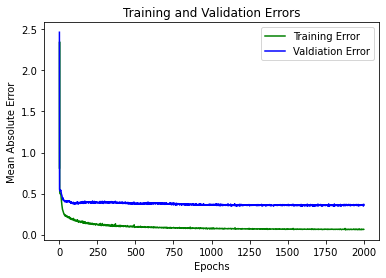

In [23]:
import matplotlib.pyplot as plt

loss_train = history.history['mae']
loss_val = history.history['val_mae']
epochs = range(1,2001)
plt.plot(epochs, loss_train, 'g', label='Training Error')
plt.plot(epochs, loss_val, 'b', label='Valdiation Error')
plt.title('Training and Validation Errors')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

In [25]:
test_loss, test_error = model.evaluate(X_test, X_test_target)
print('test_loss:', test_error)
print('test_error:', test_error)

3/3 [==============================] - 0s 9ms/step - loss: 1.6945 - mae: 0.4087
test_loss: 0.4086805284023285
test_error: 0.4086805284023285


# Prueba de Uso

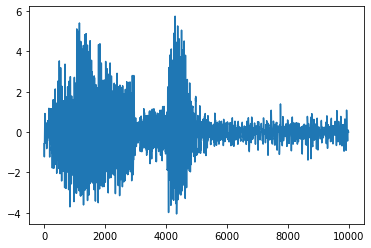

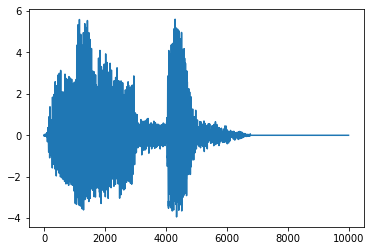

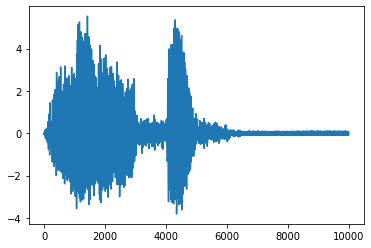

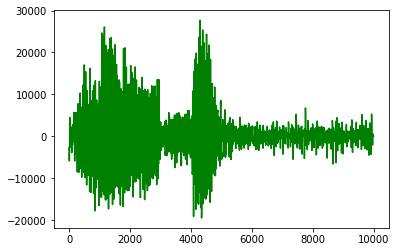

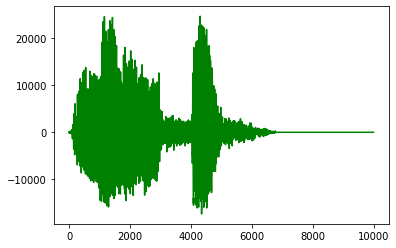

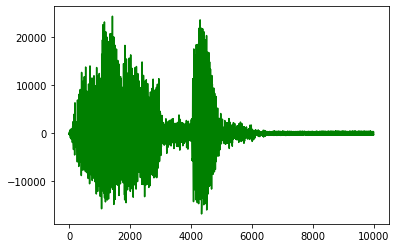

(80, 10000)

In [74]:

test = model.predict(X_test)

noisy_original = X[test_indexes,:]
original = X_target[test_indexes,:]

TEST_INDEX = 21
plt.plot(X_test[TEST_INDEX])
plt.show()

plt.plot(X_test_target[TEST_INDEX])
plt.show()

plt.plot(test[TEST_INDEX])
plt.show()

predicted = test * original.std(axis=1,ddof=1, keepdims=True)

plt.plot(noisy_original[TEST_INDEX],'g')
plt.show()

plt.plot(original[TEST_INDEX],'g')
plt.show()

plt.plot(predicted[TEST_INDEX],'g')
plt.show()



filtered_sample = np.around(predicted[TEST_INDEX]).astype('int16')

wavfile.write('original.wav',EXPECTED_HZ, original[TEST_INDEX])
wavfile.write('noisy.wav',EXPECTED_HZ, noisy_original[TEST_INDEX])
wavfile.write('reconstructed.wav',EXPECTED_HZ, filtered_sample)
np.shape(original)

# Reconstruccion

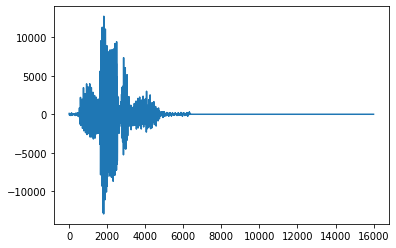

In [33]:
filteredwav = np.concatenate( [ resample(reduced,1600) for reduced in reduced_pieces] )  

filteredwav = filteredwav*palabra.std(axis=0, ddof=1) + palabra.mean(axis=0) # Tomamos los valores originales
filteredwav = np.around(filteredwav).astype('int16')

plt.plot(filteredwav)

wavfile.write('reconstructed.wav',EXPECTED_HZ, filteredwav)